In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os
import PySpin
import math

In [2]:
s1 = cv2.imread('Images/s1.jpg')
s2 = cv2.imread('Images/s2.jpg')
s3 = cv2.imread('Images/s3.jpg')
s4 = cv2.imread('Images/s4.jpg')
s5 = cv2.imread('Images/s5.jpg')
s6 = cv2.imread('Images/s6.jpg')
images = [s1,s2,s3,s4,s5,s6]

In [3]:
# Prend en entrée 3 points (1, 2 et 3) et les range dans l'ordre top-left, top-right et bottom-left.
def order(pts):
    pts_ord = np.zeros(pts.shape)
    d1 = abs(pts[0,0]-pts[1,0])
    d2 = abs(pts[0,0]-pts[2,0])
    d3 = abs(pts[2,0]-pts[1,0])
    d = min(d1,d2,d3)
    dist1 = max(d1,d2,d3)
    if d == d1:
        align1 = (0,1)
    elif d == d2:
        align1 = (0,2)
    else :
        align1 = (1,2)
    D1 = abs(pts[0,1]-pts[1,1])
    D2 = abs(pts[0,1]-pts[2,1])
    D3 = abs(pts[2,1]-pts[1,1])
    D = min(D1,D2,D3)
    dist2 = max(D1,D2,D3)
    if D == D1:
        align2 = (0,1)
    elif D == D2:
        align2 = (0,2)
    else :
        align2 = (1,2)
    for i in range(3):
        if i in align1 and i in align2 :
            pts_ord[0,0] = pts[i,0]
            pts_ord[0,1] = pts[i,1]
        elif i in align1 and dist1 > dist2 :
            pts_ord[1,0] = pts[i,0]
            pts_ord[1,1] = pts[i,1]
        else :
            pts_ord[2,0] = pts[i,0]
            pts_ord[2,1] = pts[i,1]
    return pts_ord

In [4]:
# Détermine les coordonnées des points rouges tl, tr et bl dans l'image passée en entrée.
def CamCalibrate(im):
    dst = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)
    hsv = cv2.cvtColor(dst,cv2.COLOR_BGR2HSV)
    lower_red = np.array([0,100,100])
    upper_red = np.array([10,255,255])
    mask_r = cv2.inRange(hsv,lower_red,upper_red)
    res = cv2.bitwise_and(dst,dst,mask = mask_r)
    ret,th = cv2.threshold(res[:,:,2],5,255,cv2.THRESH_BINARY)
    contours,hierarchy = cv2.findContours(th,1,1)
    print("{} contours detected".format(len(contours)))
    if len(contours) != 3 :
        print("Unexpected number of contours. Please try again (you may change brightness).")
        return(None)
    centroids = []
    for cnt in contours :
        M = cv2.moments(cnt)
        cx = M["m10"]/M["m00"]
        cy = M["m01"]/M["m00"]
        centroids.append([cx,cy])
    centroids = np.array(centroids)
    centroids = order(centroids)
    print("Centroids: {}".format(centroids))
    return centroids

In [5]:
def dist(pt1,pt2):
    return math.sqrt((pt1[0] - pt2[0]) ** 2 + (pt1[1] - pt2[1]) ** 2)

In [6]:
# Redimensionne l'écran en ne gardant que la zone encadrée par les points rouges
def resizeScreen(im,centroids):
    miny = int(centroids[2,1])
    maxy = int(centroids[1,1])
    minx = int(centroids[2,0])
    maxx = int(centroids[1,0])
    return im[miny:maxy,minx:maxx,:]

In [7]:
# Solution 1 : Brute-Force Matching with ORB Descriptors

def compareToIm(img1,img2) :
    img1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    img2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    # Initiate SIFT detector
    orb = cv2.ORB_create()
    # find the keypoints and descriptors with SIFT
    kp1, des1 = orb.detectAndCompute(img1,None)
    kp2, des2 = orb.detectAndCompute(img2,None)
    # create BFMatcher object
    bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck = True)
    # Match descriptors
    matches = bf.match(des1,des2)
    # Sort them in the order of their distance
    matches = sorted(matches, key = lambda x:x.distance)
    
    if matches is not None and des1 is not None and des2 is not None :
        dist = np.array([match.distance for match in matches])
        ratio = len(matches)/(min(len(des1),len(des2)) * np.mean(dist))
        print("Matching features ratio : {}".format(ratio))
    else :
        print("No match found.")
        
    img3 = cv2.drawMatches(img1,kp1,img2,kp2,matches[:10],None,flags=2)
    plt.imshow(img3)
    plt.show()

In [8]:
def compareToAll(img2) :
    for i in range(len(images)) :
        print("Comparing to image {} :".format(i))
        compareToIm(images[i],img2)

Library version: 1.23.0.27
Number of cameras detected: 1
Running example for camera 0...
*** DEVICE INFORMATION ***

DeviceID: 16139594
DeviceSerialNumber: 16139594
DeviceVendorName: Point Grey Research
DeviceModelName: Flea3 FL3-U3-32S2C
DeviceType: U3V
DeviceDisplayName: Point Grey Research
DeviceAccessStatus: ReadWrite
DeviceVersion: FW:v2.14.3.01 FPGA:v2.02
DeviceDriverVersion: none : 0.0.0.0
DeviceUserID: 
DeviceIsUpdater: 0
DeviceInstanceId: 00F6454A
DeviceLocation: 
DeviceCurrentSpeed: HighSpeed
GUIXMLLocation: Device
GUIXMLPath: Input.xml
GenICamXMLLocation: Device
GenICamXMLPath: 
DeviceU3VProtocol: 1
*** IMAGE ACQUISITION ***

Acquisition mode set to continuous...
Acquiring images...
Device serial number retrieved as 16139594...
Processing... Please wait... This will take less than a minute...
3 contours detected
Centroids: [[1834.73072788  221.2252577 ]
 [1831.71237039  915.04966647]
 [ 527.50671198  228.4722175 ]]
Comparing to image 0 :
Matching features ratio : 0.004850120

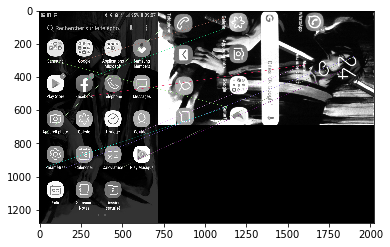

Comparing to image 1 :
Matching features ratio : 0.002705559078418939


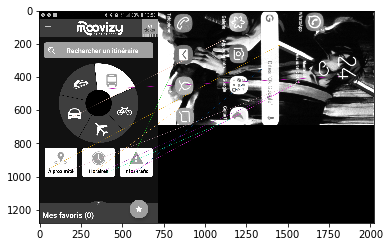

Comparing to image 2 :
Matching features ratio : 0.0033106174799477


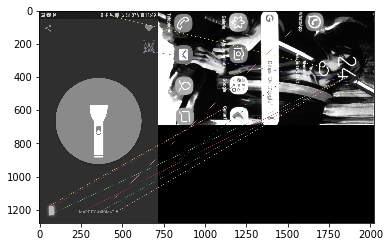

Comparing to image 3 :
Matching features ratio : 0.0012902198152277794


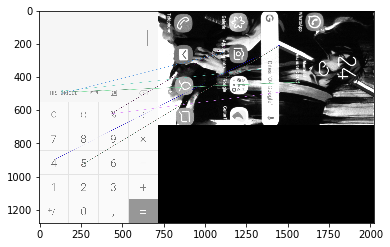

Comparing to image 4 :
Matching features ratio : 0.0023230056111246647


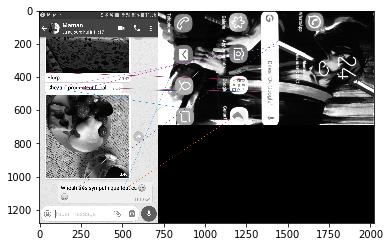

Comparing to image 5 :
Matching features ratio : 0.007081984065792855


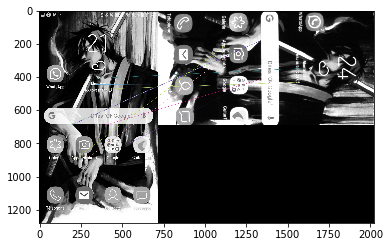

Comparing to image 0 :
Matching features ratio : 0.003250207262477201


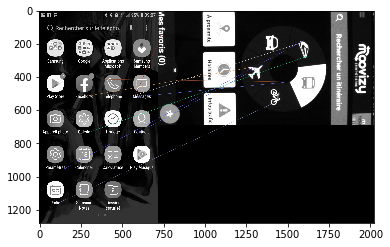

Comparing to image 1 :
Matching features ratio : 0.0076128236744759555


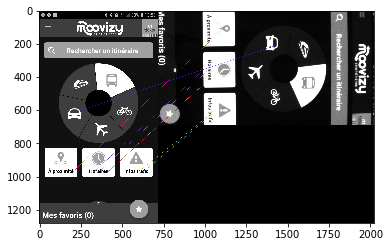

Comparing to image 2 :
Matching features ratio : 0.0027404366654637316


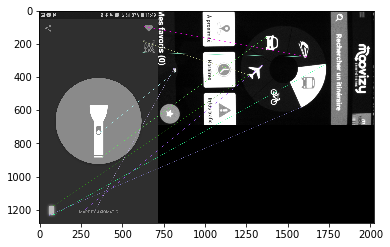

Comparing to image 3 :
Matching features ratio : 0.0026944777911164465


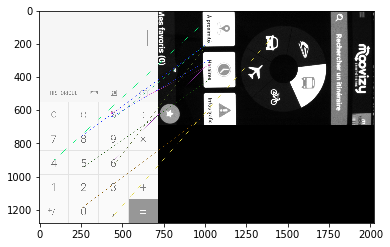

Comparing to image 4 :
Matching features ratio : 0.0040615950356239945


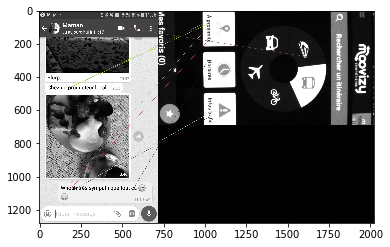

Comparing to image 5 :
Matching features ratio : 0.0032834170854271357


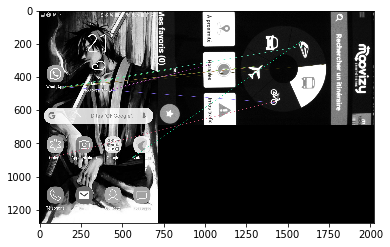

Comparing to image 0 :
Matching features ratio : 0.004287657644891597


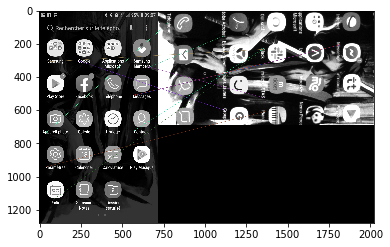

Comparing to image 1 :
Matching features ratio : 0.003236670106639147


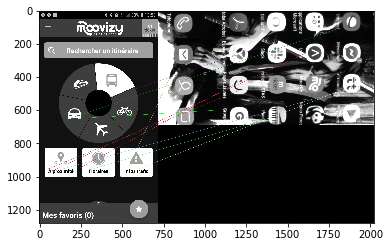

Comparing to image 2 :
Matching features ratio : 0.0033111871955697875


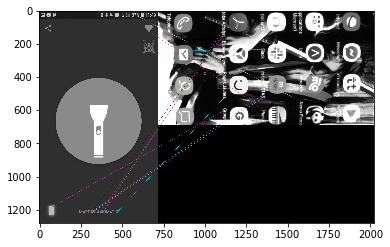

Comparing to image 3 :
Matching features ratio : 0.0016260492040520986


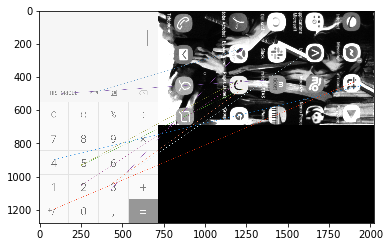

Comparing to image 4 :
Matching features ratio : 0.0026332484824750342


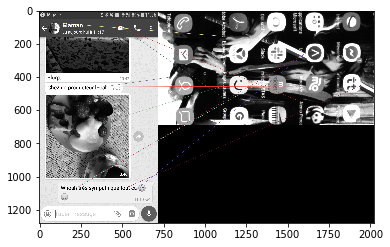

Comparing to image 5 :
Matching features ratio : 0.004438104941416199


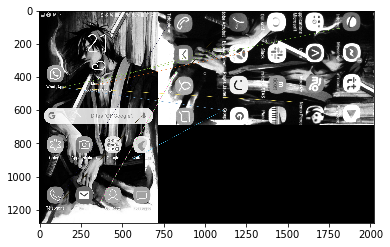

Comparing to image 0 :
Matching features ratio : 0.006908862981070577


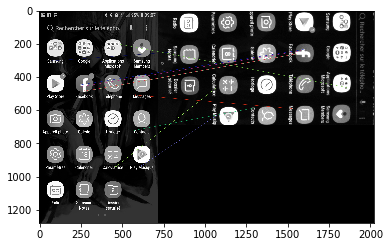

Comparing to image 1 :
Matching features ratio : 0.002859461325966851


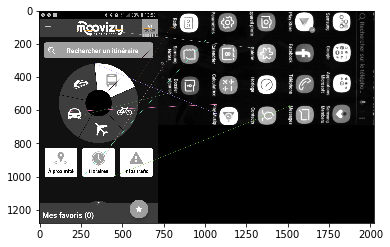

Comparing to image 2 :
Matching features ratio : 0.0028588012883650166


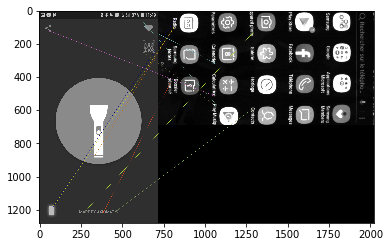

Comparing to image 3 :
Matching features ratio : 0.0014081205525324403


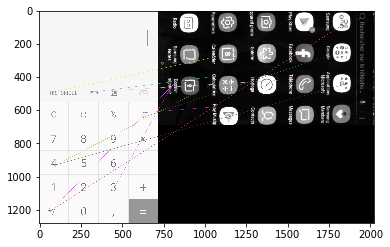

Comparing to image 4 :
Matching features ratio : 0.0017249640632486826


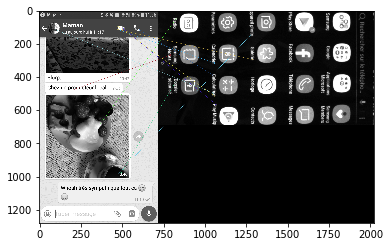

Comparing to image 5 :
Matching features ratio : 0.00400731850117096


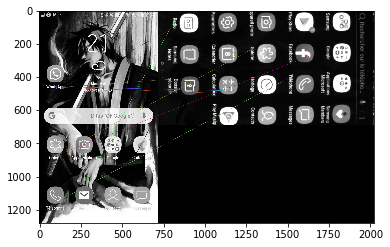

Comparing to image 0 :
Matching features ratio : 0.0032770515613652867


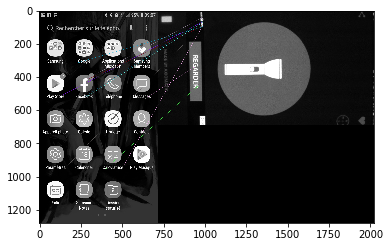

Comparing to image 1 :
Matching features ratio : 0.0021914844649021862


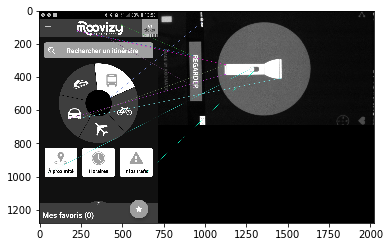

Comparing to image 2 :
Matching features ratio : 0.0027920007884817038


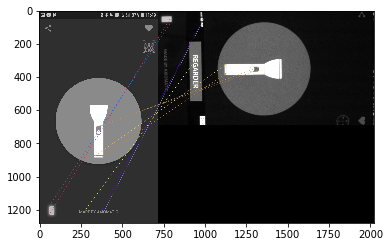

Comparing to image 3 :
Matching features ratio : 0.0011434217955957086


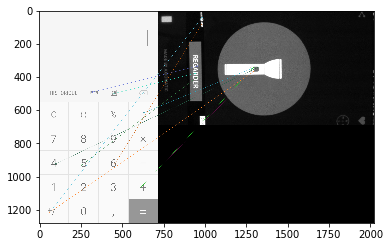

Comparing to image 4 :
Matching features ratio : 0.0015695652173913042


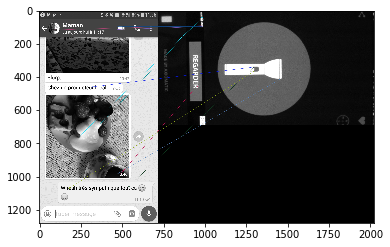

Comparing to image 5 :
Matching features ratio : 0.003316751269035533


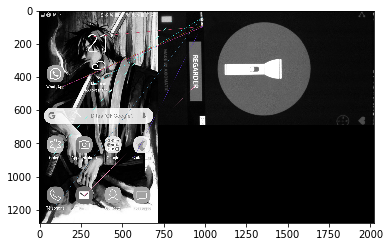

Comparing to image 0 :
Matching features ratio : 0.0023175621491579794


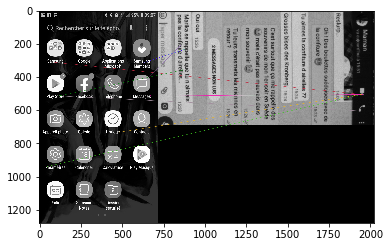

Comparing to image 1 :
Matching features ratio : 0.0047620312961322705


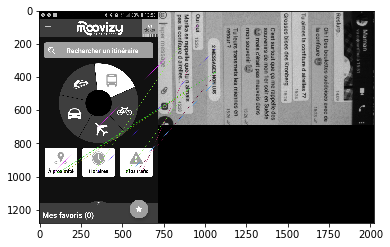

Comparing to image 2 :
Matching features ratio : 0.0020973345864602473


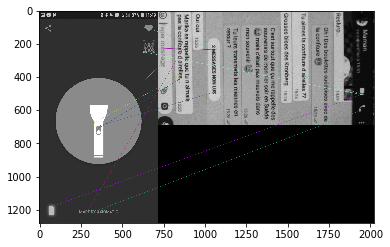

Comparing to image 3 :
Matching features ratio : 0.0027863059083379346


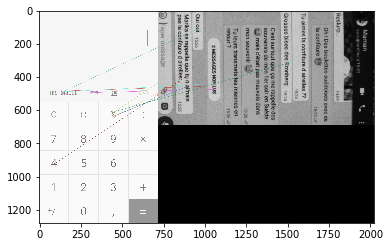

Comparing to image 4 :
Matching features ratio : 0.005468354430379747


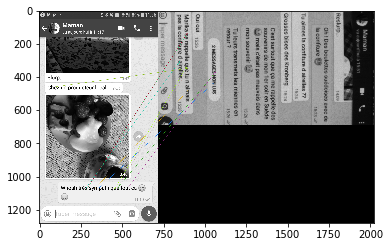

Comparing to image 5 :
Matching features ratio : 0.0029219594594594596


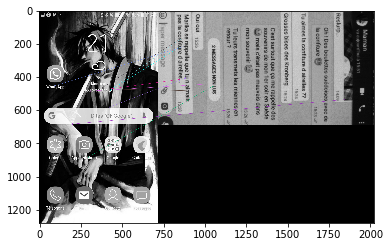

Comparing to image 0 :
Matching features ratio : 0.0016276574607589907


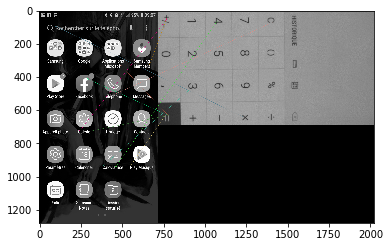

Comparing to image 1 :
Matching features ratio : 0.002205114401076716


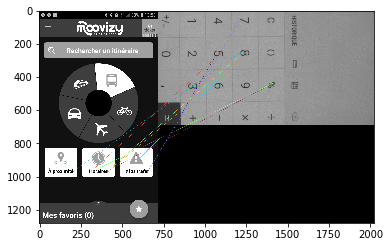

Comparing to image 2 :
Matching features ratio : 0.001328724320845401


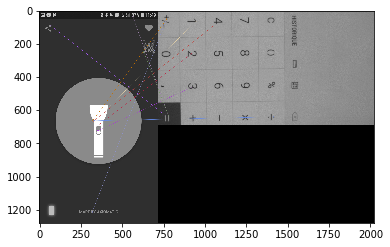

Comparing to image 3 :
Matching features ratio : 0.006103331067301155


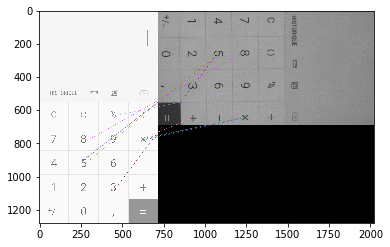

Comparing to image 4 :
Matching features ratio : 0.002660862683023348


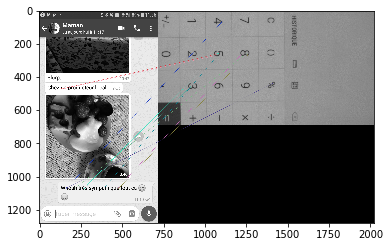

Comparing to image 5 :
Matching features ratio : 0.001838141434771509


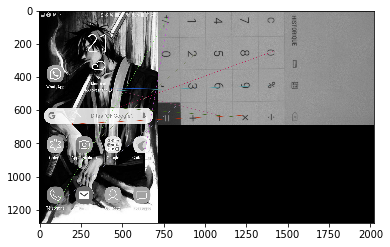

Camera 0 example complete... 

Done! Press Enter to exit...


In [9]:
def acquire_images(cam, nodemap, nodemap_tldevice):
    """
    This function shows images from a device.

    :param cam: Camera to acquire images from.
    :param nodemap: Device nodemap.
    :param nodemap_tldevice: Transport layer device nodemap.
    :type cam: CameraPtr
    :type nodemap: INodeMap
    :type nodemap_tldevice: INodeMap
    :return: True if successful, False otherwise.
    :rtype: bool
    """

    print('*** IMAGE ACQUISITION ***\n')
    try:
        result = True
        centroids = None
        

        # Set acquisition mode to continuous
        #
        #  Retrieve enumeration node from nodemap
        
        # In order to access the node entries, they have to be casted to a pointer type (CEnumerationPtr here)
        node_acquisition_mode = PySpin.CEnumerationPtr(nodemap.GetNode('AcquisitionMode'))
        if not PySpin.IsAvailable(node_acquisition_mode) or not PySpin.IsWritable(node_acquisition_mode):
            print('Unable to set acquisition mode to continuous (enum retrieval). Aborting...')
            return False

        # Retrieve entry node from enumeration node
        node_acquisition_mode_continuous = node_acquisition_mode.GetEntryByName('Continuous')
        if not PySpin.IsAvailable(node_acquisition_mode_continuous) or not PySpin.IsReadable(node_acquisition_mode_continuous):
            print('Unable to set acquisition mode to continuous (entry retrieval). Aborting...')
            return False

        # Retrieve integer value from entry node
        acquisition_mode_continuous = node_acquisition_mode_continuous.GetValue()

        # Set integer value from entry node as new value of enumeration node
        node_acquisition_mode.SetIntValue(acquisition_mode_continuous)

        print('Acquisition mode set to continuous...')

        #  Begin acquiring images
        cam.BeginAcquisition()

        print('Acquiring images...')

        #  Retrieve device serial number
        device_serial_number = ''
        node_device_serial_number = PySpin.CStringPtr(nodemap_tldevice.GetNode('DeviceSerialNumber'))
        if PySpin.IsAvailable(node_device_serial_number) and PySpin.IsReadable(node_device_serial_number):
            device_serial_number = node_device_serial_number.GetValue()
            print('Device serial number retrieved as %s...' % device_serial_number)

        # Retrieve, convert, and show images
        cv2.namedWindow('im', cv2.WINDOW_NORMAL)

        while(1):
            try:
            
            #  Retrieve next received image
                image_result = cam.GetNextImage()

            #  Ensure image completion
                if image_result.IsIncomplete():
                    print('Image incomplete with image status %d ...' % image_result.GetImageStatus())

                else:
                    width = image_result.GetWidth()
                    height = image_result.GetHeight()

                    row_bytes = float(len(image_result.GetData()))/width
                    rawFrame = np.array(image_result.GetData(), dtype = "uint8").reshape(height,width)
                    im = cv2.cvtColor(rawFrame,cv2.COLOR_BAYER_BG2BGR)                   
                    cv2.imshow('im',im)
                    
                    k = cv2.waitKey(10) & 0xFF
                    if k == ord('q') :
                        break
                    elif k == ord('c') :
                        print("Processing... Please wait... This will take less than a minute...")
                        dst = cv2.fastNlMeansDenoisingColored(im,None,10,10,7,21)
                        centroids = CamCalibrate(dst)

                    elif k == ord('y') and centroids is not None :
                        im2 = resizeScreen(im,centroids)
                        cv2.imshow('resized',im2)
                        compareToAll(im2)

                        
                    #  Release image
                    image_result.Release()

            except PySpin.SpinnakerException as ex:
                print('Error: %s' % ex)
                return False
            
        cv2.destroyAllWindows()       
            
        #  End acquisition
        cam.EndAcquisition()
    
    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        return False

    return result


def print_device_info(nodemap):
    """
    This function prints the device information of the camera from the transport
    layer; please see NodeMapInfo example for more in-depth comments on printing
    device information from the nodemap.

    :param nodemap: Transport layer device nodemap.
    :type nodemap: INodeMap
    :returns: True if successful, False otherwise.
    :rtype: bool
    """

    print('*** DEVICE INFORMATION ***\n')

    try:
        result = True
        node_device_information = PySpin.CCategoryPtr(nodemap.GetNode('DeviceInformation'))

        if PySpin.IsAvailable(node_device_information) and PySpin.IsReadable(node_device_information):
            features = node_device_information.GetFeatures()
            for feature in features:
                node_feature = PySpin.CValuePtr(feature)
                print('%s: %s' % (node_feature.GetName(),
                                  node_feature.ToString() if PySpin.IsReadable(node_feature) else 'Node not readable'))

        else:
            print('Device control information not available.')

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        return False

    return result


def run_single_camera(cam):
    """
    This function acts as the body of the example; please see NodeMapInfo example
    for more in-depth comments on setting up cameras.

    :param cam: Camera to run on.
    :type cam: CameraPtr
    :return: True if successful, False otherwise.
    :rtype: bool
    """
    try:
        result = True

        # Retrieve TL device nodemap and print device information
        nodemap_tldevice = cam.GetTLDeviceNodeMap()

        result &= print_device_info(nodemap_tldevice)

        # Initialize camera
        cam.Init()

        # Retrieve GenICam nodemap
        nodemap = cam.GetNodeMap()

        # Acquire images
        result &= acquire_images(cam, nodemap, nodemap_tldevice)

        # Deinitialize camera
        cam.DeInit()

    except PySpin.SpinnakerException as ex:
        print('Error: %s' % ex)
        result = False

    return result


def main():
    """
    Example entry point; please see Enumeration example for more in-depth
    comments on preparing and cleaning up the system.

    :return: True if successful, False otherwise.
    :rtype: bool
    """

    # Since this application saves images in the current folder
    # we must ensure that we have permission to write to this folder.
    # If we do not have permission, fail right away.
    try:
        test_file = open('test.txt', 'w+')
    except IOError:
        print('Unable to write to current directory. Please check permissions.')
        input('Press Enter to exit...')
        return False

    test_file.close()
    os.remove(test_file.name)

    result = True

    # Retrieve singleton reference to system object
    system = PySpin.System.GetInstance()

    # Get current library version
    version = system.GetLibraryVersion()
    print('Library version: %d.%d.%d.%d' % (version.major, version.minor, version.type, version.build))

    # Retrieve list of cameras from the system
    cam_list = system.GetCameras()

    num_cameras = cam_list.GetSize()

    print('Number of cameras detected: %d' % num_cameras)

    # Finish if there are no cameras
    if num_cameras == 0:

        # Clear camera list before releasing system
        cam_list.Clear()

        # Release system instance
        system.ReleaseInstance()

        print('Not enough cameras!')
        input('Done! Press Enter to exit...')
        return False

    # Run example on each camera
    for i, cam in enumerate(cam_list):

        print('Running example for camera %d...' % i)

        result &= run_single_camera(cam)
        print('Camera %d example complete... \n' % i)

    # Release reference to camera
    # NOTE: Unlike the C++ examples, we cannot rely on pointer objects being automatically
    # cleaned up when going out of scope.
    # The usage of del is preferred to assigning the variable to None.
    del cam

    # Clear camera list before releasing system
    cam_list.Clear()

    # Release system instance
    system.ReleaseInstance()

    input('Done! Press Enter to exit...')
    return result

if __name__ == '__main__':
    main()

In [10]:
cv2.destroyAllWindows()